<a href="https://colab.research.google.com/github/yohanesnuwara/computational-geophysics/blob/master/seismic/seis_attribute.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialize

In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!pip install segyio

     |████████████████████████████████| 92kB 3.7MB/s 


In [0]:
import segyio

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
!git clone https://github.com/yohanesnuwara/computational-geophysics

Cloning into 'computational-geophysics'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 254 (delta 7), reused 0 (delta 0), pack-reused 237
Receiving objects: 100% (254/254), 23.26 MiB | 29.37 MiB/s, done.
Resolving deltas: 100% (128/128), done.


In [0]:
import sys
sys.path.append('/content/computational-geophysics/seismic')

In [7]:
!git clone https://github.com/yohanesnuwara/d2geo

Cloning into 'd2geo'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 78 (delta 9), reused 0 (delta 0), pack-reused 52
Unpacking objects: 100% (78/78), done.


In [0]:
import sys
sys.path.append('/content/d2geo/attributes')

# Read Data 3D

In [0]:
filename = '/content/drive/My Drive/Public geoscience Data/Dutch F3 seismic data/Dutch Government_F3_entire_8bit seismic.segy'

In [10]:
import segyio

with segyio.open(filename) as f:

  data = segyio.tools.cube(f)
  inline_data = f.iline
  crossline_data = f.xline

  inlines = f.ilines
  crosslines = f.xlines
  twt = f.samples
  sample_rate = segyio.tools.dt(f) / 1000
  print('Inline range from', inlines[0], 'to', inlines[-1])
  print('Crossline range from', crosslines[0], 'to', crosslines[-1])
  print('TWT from', twt[0], 'to', twt[-1])   
  print('Sample rate:', sample_rate, 'ms')

  clip_percentile = 99
  vm = np.percentile(data, clip_percentile)

f'The {clip_percentile}th percentile is {vm:.0f}; the max amplitude is {data.max():.0f}'

Inline range from 100 to 750
Crossline range from 300 to 1250
TWT from 4.0 to 1848.0
Sample rate: 4.0 ms


'The 99th percentile is 6517; the max amplitude is 32767'

# `seis_attribute`

In [0]:
def attribute_2d(cube, type='il', inline_loc=400, xline_loc=1000, 
                 timeslice_loc=1404, attribute_class='CompleTrace', 
                 attribute_type='cosphase', kernel=None, sample_rate=4, 
                 dip_factor=10, axis=-1):
  """
  Computing attribute of a 3D cube, output a 2D attribute slice 
  (Copyright, Y. Nuwara, ign.nuwara97@gmail.com)

  Input:

  cube: 3D seismic data output of segyio.tools.cube (3D numpy array)
  type: specify the type of slice
    * 'il' for inline
    * 'xl' for crossline
    * 'ts' for timeslice)
  inline_loc: preferred location of inline, if you specify type='il', 
              no need to input xline_loc, timeslice_loc
  xline_loc: preferred location of crossline, if you specify type='xl', 
             no need to input inline_loc, timeslice_loc
  timeslice_loc: preferred location of timeslice, if you specify type='ts', 
                 no need to input inline_loc, xline_loc
  
  attribute_class: specify the class of attribute (string)
    * 'Amplitude': amplitude attributes
    * 'CompleTrace': complex trace attributes
    * 'DipAzm': dip and azimuth attributes
    * 'EdgeDetection': edge detection attributes

  attribute_type: specify the attribute type (string). 
  
  Note. Please read DOCS for input-output (i/o) of each attribute, here:
  https://github.com/yohanesnuwara/computational-geophysics/edit/master/seismic/README.md

  Each class has different attribute types, as follows.

    * For class 'Amplitude', attributes are:

      * 'fder': first derivative
      * 'sder': second derivative
      * 'rms': rms of trace value (e.g. amplitude)
      * 'gradmag': gradient magnitude using Gaussian operator
      * 'reflin': reflection intensity

    * For class 'CompleTrace', attributes are: 
      * 'enve': envelope
      * 'inphase': instantaneous phase 
      * 'cosphase': cosine instantaneous phase 
      * 'ampcontrast': relative amplitude contrast
      * 'ampacc': amplitude acceleration
      * 'infreq': instantaneous frequency 
      * 'inband': instantaneous bandwidth
      * 'domfreq': dominant frequency 
      * 'freqcontrast': frequency change 
      * 'sweet': sweetness 
      * 'quality': quality factor 
      * 'resphase': response phase 
      * 'resfreq': response frequency 
      * 'resamp': response amplitude 
      * 'apolar': apparent polarity

    * For class 'DipAzm', attributes are: 
      * 'dipgrad': gradient dips from inline, crossline, and z-gradients 
      * 'gst': the gradient structure tensors (GST), inner product of 
        gradients.
      * 'gstdip2d': 2D gradient dips from GST
      * 'gstdip3d': 3D gradient dips from GST
      * 'gstazm3d': 3D azimuth from GST
    
    * For class 'EdgeDetection', attributes are:
      * 'semblance': semblance
      * 'gstdisc': discontinuity from eigenvalues of GST
      * 'eigen': multi-trace semblance from 3D seismic incorporating the 
                analytic trace
      * 'chaos': multi-trace chaos from 3D seismic
      * 'curv': volume curvature from 3D seismic dips

  """

  import numpy as np
  import segyio
  from CompleTrace import ComplexAttributes
  from DipAzm import DipAzm
  from EdgeDetection import EdgeDetection
  from Frequency import Frequency
  from SignalProcess import SignalProcess

  # slicing the 3D cube based on inline, crossline, or timeslice selection
  # processing input to attribute computation 

  if type == 'il':
    with segyio.open(filename) as f: 
        slices = f.iline[inline_loc]  

    darray = np.reshape(slices, slices.shape + (1,))

  if type == 'xl':
    with segyio.open(filename) as f:
        slices = f.xline[xline_loc] 

    darray = np.reshape(slices, slices.shape + (1,))  
  
  if type == 'ts':
    id = np.where(twt == timeslice_loc)[0][0]
    slices = data[:,:,id]

    darray = np.reshape(np.transpose(slices), (np.transpose(slices)).shape + (1,))
  
  # attribute computation

  if attribute_class == 'Amplitude':
    x = SignalProcess()
    darray, chunks_init = SignalProcess.create_array(x, darray, kernel, preview=None)  
    darray = darray.T

    if attribute_type == 'fder':
      result = SignalProcess.first_derivative(x, darray, axis=-1, preview=None)
    
    if attribute_type == 'sder':
      result = SignalProcess.second_derivative(x, darray, axis=-1, preview=None)

    if attribute_type == 'rms':
      result = SignalProcess.rms(x, darray, kernel=(1,1,9), preview=None)

    if attribute_type == 'gradmag':
      result = SignalProcess.gradient_magnitude(x, darray, sigmas=(1,1,1), preview=None)

    if attribute_type == 'reflin':
      result = SignalProcess.reflection_intensity(x, darray, kernel=(1,1,9), preview=None)

  if attribute_class == 'CompleTrace':  
    x = ComplexAttributes()
    darray, chunks_init = ComplexAttributes.create_array(x, darray, kernel, preview=None)
    darray = darray.T

    if attribute_type == 'enve':
      result = ComplexAttributes.envelope(x, darray, preview=None)

    if attribute_type == 'inphase':
      result = ComplexAttributes.instantaneous_phase(x, darray, preview=None)   

    if attribute_type == 'cosphase':
      result = ComplexAttributes.cosine_instantaneous_phase(x, darray, preview=None)   

    if attribute_type == 'ampcontrast':
      result = ComplexAttributes.relative_amplitude_change(x, darray, preview=None)
    
    if attribute_type == 'ampacc':
      result = ComplexAttributes.amplitude_acceleration(x, darray, preview=None)
    
    if attribute_type == 'infreq':
      result = ComplexAttributes.instantaneous_frequency(x, darray, sample_rate=4, preview=None)

    if attribute_type == 'inband':
      result = ComplexAttributes.instantaneous_bandwidth(x, darray, preview=None)
    
    if attribute_type == 'domfreq':
      result = ComplexAttributes.dominant_frequency(x, darray, sample_rate=4, preview=None)

    if attribute_type == 'freqcontrast':
      result = ComplexAttributes.dominant_frequency(x, darray, sample_rate=4, preview=None)

    if attribute_type == 'sweet':
      result = ComplexAttributes.sweetness(x, darray, sample_rate=4, preview=None)

    if attribute_type == 'quality':
      result = ComplexAttributes.quality_factor(x, darray, sample_rate=4, preview=None)
    
    if attribute_type == 'resphase':
      result = ComplexAttributes.response_phase(x, darray, preview=None)

    if attribute_type == 'resfreq':
      result = ComplexAttributes.response_frequency(x, darray, sample_rate=4, preview=None)
    
    if attribute_type == 'resamp':
      result = ComplexAttributes.response_amplitude(x, darray, preview=None)

    if attribute_type == 'apolar':
      result = ComplexAttributes.apparent_polarity(x, darray, preview=None)

  if attribute_class == 'DipAzm':
    x = DipAzm()
    darray, chunks_init = DipAzm.create_array(x, darray, kernel=None, preview=None)
    darray = darray.T

    if attribute_type == 'dipgrad':
      il_dip, xl_dip = DipAzm.gradient_dips(x, darray, dip_factor=10, kernel=(3,3,3), preview=None)

    if attribute_type == 'gst':
      gi2, gj2, gk2, gigj, gigk, gjgk = DipAzm.gradient_structure_tensor(x, darray, kernel, preview=None)
    
    if attribute_type == 'gstdip2d':
      il_dip, xl_dip = DipAzm.gst_2D_dips(x, darray, dip_factor=10, kernel=(3,3,3), preview=None)

    if attribute_type == 'gstdip3d':
      result = DipAzm.gst_3D_dip(x, darray, dip_factor=10, kernel=(3,3,3), preview=None)

    if attribute_type == 'gstazm3d':
      result = DipAzm.gst_3D_azm(x, darray, dip_factor=10, kernel=(3,3,3), preview=None)


  if attribute_class == 'EdgeDetection':  
    x = EdgeDetection()
    darray, chunks_init = EdgeDetection.create_array(x, darray, kernel, preview=None)
    darray = darray.T

    if attribute_type == 'semblance':
      result = EdgeDetection.semblance(x, darray, kernel=(3,3,9), preview=None)

    if attribute_type == 'gstdisc':
      result = EdgeDetection.gradient_structure_tensor(x, darray, kernel=(3,3,9), preview=None)
    
    if attribute_type == 'eigen':
      result = EdgeDetection.eig_complex(x, darray, kernel=(3,3,9), preview=None)

    if attribute_type == 'chaos':
      result = EdgeDetection.chaos(x, darray, kernel=(3,3,9), preview=None)

    if attribute_type == 'curv':
      # compute first inline and xline dips from gst
      x = DipAzm()
      darray_il, darray_xl = DipAzm.gradient_dips(x, darray, dip_factor=10, kernel=(3,3,3), preview=None)
      # compute curvature
      H, K, Kmax, Kmin, KMPos, KMNeg = EdgeDetection.volume_curvature(x, darray_il, darray_xl, dip_factor=10, kernel=(3,3,3), 
                         preview=None) 
  
  # return(result, il_dip, xl_dip, gi2, gj2, gk2, gigj, gigk, gjgk, H, K, Kmax, Kmin, KMPos, KMNeg)
  return(result)

In [83]:
help(attribute_2d)

Help on function attribute_2d in module __main__:

attribute_2d(cube, type='il', inline_loc=400, xline_loc=1000, timeslice_loc=1404, attribute_class='CompleTrace', attribute_type='Envelope', kernel=None, sample_rate=4, dip_factor=10, axis=-1)
    Computing attribute of a 3D cube, output a 2D attribute slice 
    (Copyright, Y. Nuwara, ign.nuwara97@gmail.com)
    
    Input:
    
    cube: 3D seismic data output of segyio.tools.cube (3D numpy array)
    type: specify the type of slice
      * 'il' for inline
      * 'xl' for crossline
      * 'ts' for timeslice)
    inline_loc: preferred location of inline, if you specify type='il', 
                no need to input xline_loc, timeslice_loc
    xline_loc: preferred location of crossline, if you specify type='xl', 
               no need to input inline_loc, timeslice_loc
    timeslice_loc: preferred location of timeslice, if you specify type='ts', 
                   no need to input inline_loc, xline_loc
    
    attribute_class: speci

# Test Class Amplitude Attributes

## First Derivative

### Inline

In [216]:
result = attribute_2d(cube=data, type='il', inline_loc=400, attribute_class='CompleTrace', attribute_type='apolar')
result

dask.array<where, shape=(1, 462, 951), dtype=float32, chunksize=(1, 461, 461), chunktype=numpy.ndarray>

In [89]:
from seis_util import display_attribute

help(display_attribute)

Help on function display_attribute in module seis_util:

display_attribute(computed_attribute, type, b_line, c_line, cmap, vmin, vmax)
    Processing the output from d2geo attribute for matplotlib display
    
    Input:
    
    computed_attribute: output from the attribute computation (3D Dask array)
    type: 'il' for inline, 'xl' for crossline, 'ts' for timeslice
    
    b_line, c_line: array of inline, crossline, and timeslice, depends on the 
                    type you're choosing (1D numpy array)
    * for 'il': b_line = crossline array, c_line = twt array
    * for 'xl': b_line = inline array, c_line = twt array
    * for 'ts': b_line = inline array, c_line = crossline array
    
    cmap: matplotlib pyplot colormaps ('gray', 'RdBu', 'seismic', 
          jet, Accent, ...)
    vmin, vmax: the minimum and maximum range for colormap. Many options:
    * None, None: normal and default plotting
    * specified vmin, vmax (e.g. vmin = 0, vmax = 1000)
    * vmin = -percentile99, v

/content/d2geo/attributes/util.py:347: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  h = h[ind]


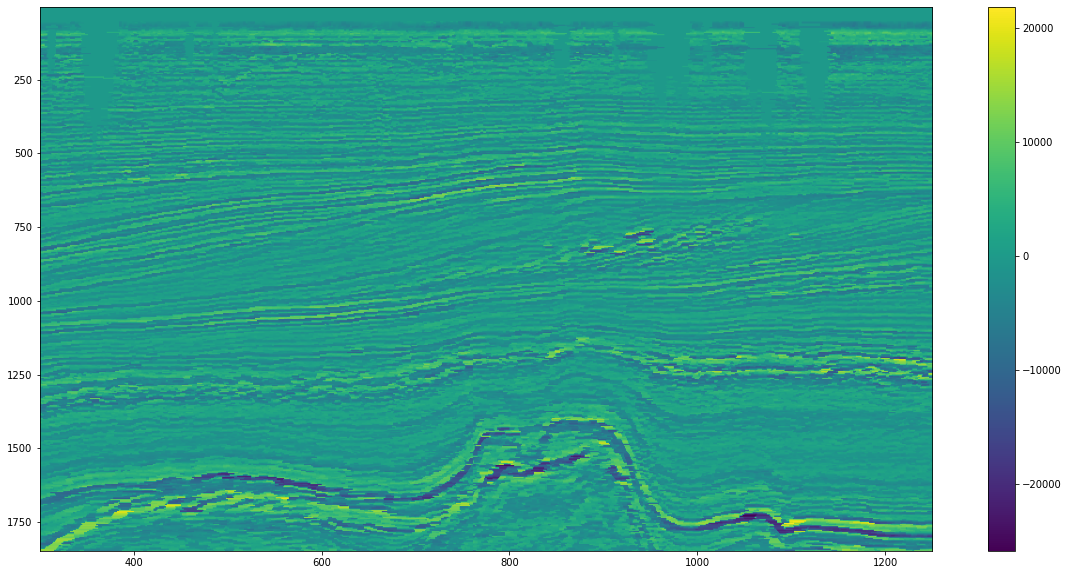

In [217]:
plt.figure(figsize=(20,10))
display_attribute(result, 'il', crosslines, twt, 'viridis', None, None)